In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from iou import general_iou
from anchor_utils import kmeans,get_anchor_boxes,get_boxes
import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
boxes=get_boxes('data/train.txt')
clusters,nearst_cluster,distances=get_anchor_boxes('data/train.txt',9)

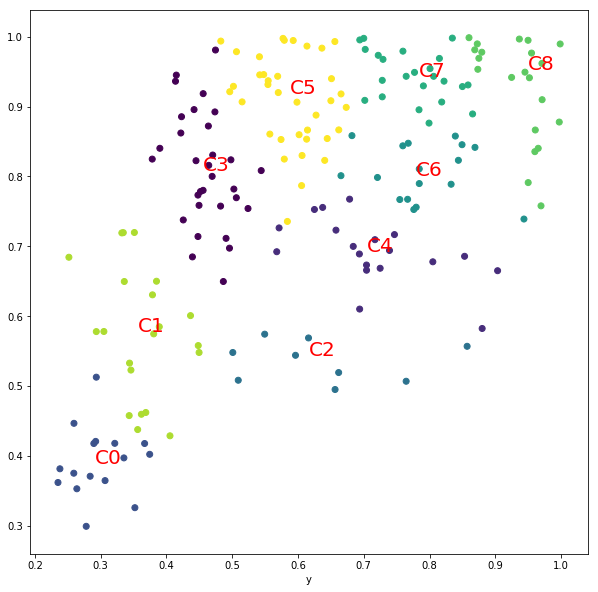

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(boxes[:,0],boxes[:,1],c=nearst_cluster)
for i,c in enumerate(clusters):
    plt.text(c[0],c[1],'C%d'%i,fontsize=20,color='red')
plt.xlabel('x')
plt.xlabel('y')

In [4]:
def anchorBox2Img(anchorbox,baseUnit=50):
    COLORS=[(255,0,0),(0,255,0),(0,0,255)]
     
    anchor_boxes=sorted(anchorbox,key=lambda x:x[0]*x[1])
    Ws=[int(baseUnit*box[0]) for box in anchor_boxes]
    #注意uint32,设置8溢出错误
    offset=np.cumsum (np.concatenate([[0.0],Ws]) ).astype(np.uint32)

    Hs=[int(baseUnit*box[1]) for box in anchor_boxes]
    WW,HH=sum(Ws),max(Hs)
    I=np.zeros((HH,WW,3),np.uint8)
    
    for i in range(len(Hs)):
        s=offset[i]
        pt1=(s,0)
        pt2=(s+Ws[i],Hs[i])
        I=cv2.rectangle(I,pt1,pt2,COLORS[i%3],-1)
        I=cv2.putText(I,'C%d'%i,(s+Ws[i]//2-10,Hs[i]//2),cv2.FONT_ITALIC,2,0.5,3)
    return I

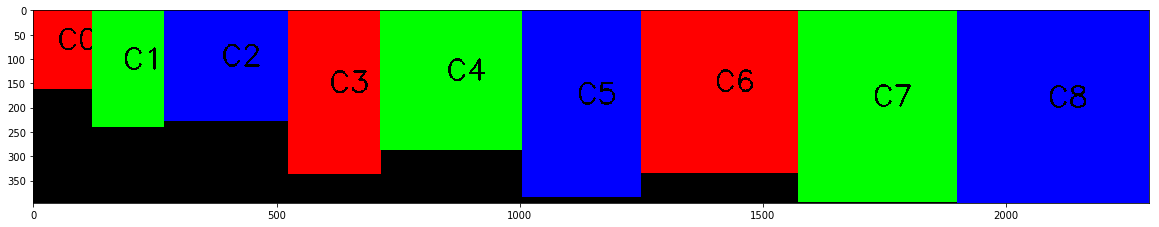

In [5]:
I=anchorBox2Img(clusters,416,seed=26)
plt.figure(figsize=(20,20))
plt.imshow(I)

In [2]:
from dbutils import ImageDataset,load_anchor_boxes

In [3]:
GRID_SIZE,IMG_SIZE,C=13,416,2

In [4]:
anchor_boxes=load_anchor_boxes('data/raccoon_my_anchors.txt',IMG_SIZE,IMG_SIZE)
anchor_boxes=anchor_boxes.tolist()

In [49]:
def get_label_boxes(I,y):
    H,W=I.shape[0:2]
    gh, gw = y.shape[0:2]
    cellX,cellY=W//gw,H//gh
    
    logit = y[:, :, :, 4]  # (gh,gw,a)
    mask = logit > 0
    indices = np.where(mask)
    indices = np.array(indices)
    indices = indices.transpose()  # (#gt,3) 3=(i,j,a)

    # (#gt,5+C)
    labelobj = y[mask]

    y = cellY * indices[:, 0]
    x = cellX * indices[:, 1]

    labelobj_anchor = indices[:, 2]

    labelobj_cx = labelobj[:, 0] * cellX + x
    labelobj_cy = labelobj[:, 1] * cellY + y
    labelobj_w = labelobj[:, 2]
    labelobj_h = labelobj[:, 3]
    labelobj_classes = labelobj[:, 5:]

    labelobj_x1 =np.uint32(labelobj_cx - 0.5 * labelobj_w)
    labelobj_y1 =np.uint32(labelobj_cy - 0.5 * labelobj_h)
    labelobj_x2 =np.uint32(labelobj_cx + 0.5 * labelobj_w)
    labelobj_y2 =np.uint32(labelobj_cy + 0.5 * labelobj_h)

    
    return labelobj_x1,labelobj_y1,labelobj_x2,labelobj_y2,labelobj_anchor,labelobj_classes
def drawBox(I,x1,y1,x2,y2,anchor,classes,alpha=0.4):
    COLORS=[(128,0,0),(0,128,0),(0,0,128)]
    COLORS_CENTER=[(255,0,0),(0,255,0),(0,0,255)]
    orgin=I
    
    n=len(x1)
    I=I.copy()
    for i in range(n):
        I=cv2.rectangle(I,(x1[i],y1[i]),(x2[i],y2[i]),COLORS[anchor[i]],-1)
        I=cv2.addWeighted(I,alpha,orgin,1-alpha,0) 
        I=cv2.circle(I,((x1[i]+x2[i])//2,(y1[i]+y2[i])//2),2,COLORS_CENTER[anchor[i]],2,-1)
        orgin=I.copy()
    return I 
def decodeGridImage(img,y,color,linewidth):
    I=img.copy()
    H,W=I.shape[0:2]
    gH,gW=y.shape[0:2]
    cellx,celly=W//gW,H//gH
#     horiziontal fix x,change y
    for r in range(1,gH):
        pt1=(0,r*celly)
        pt2=(W,r*celly)
        I=cv2.line(I,pt1,pt2,color,linewidth)
#     vertical fix y change x
    for c in range(1,gW):
        pt1=(c*cellx,0)
        pt2=(c*cellx,H)
        I=cv2.line(I,pt1,pt2,color,linewidth)
    vx1,vy1,vx2,vy2,va,vclasses=get_label_boxes(I,y)
    I=drawBox(I,vx1,vy1,vx2,vy2,va,vclasses,alpha=0.4)
    return I
def decodeImage(image,y1,y2,y3,color=(255,0,0),linewidth=[5,2,1]):
    image=np.uint8(image*255)
    image13=decodeGridImage(image,y1,color,linewidth[0])
    image26=decodeGridImage(image,y2,color,linewidth[1])
    image52=decodeGridImage(image,y3,color,linewidth[2])
    
    
    return image,image13,image26,image52

In [62]:
db=ImageDataset(GRID_SIZE,IMG_SIZE,anchor_boxes,C)
iterator=db.build_example('data/sample.txt',1,1,shuffle=False,eager=True)

(-0.5, 415.5, 415.5, -0.5)

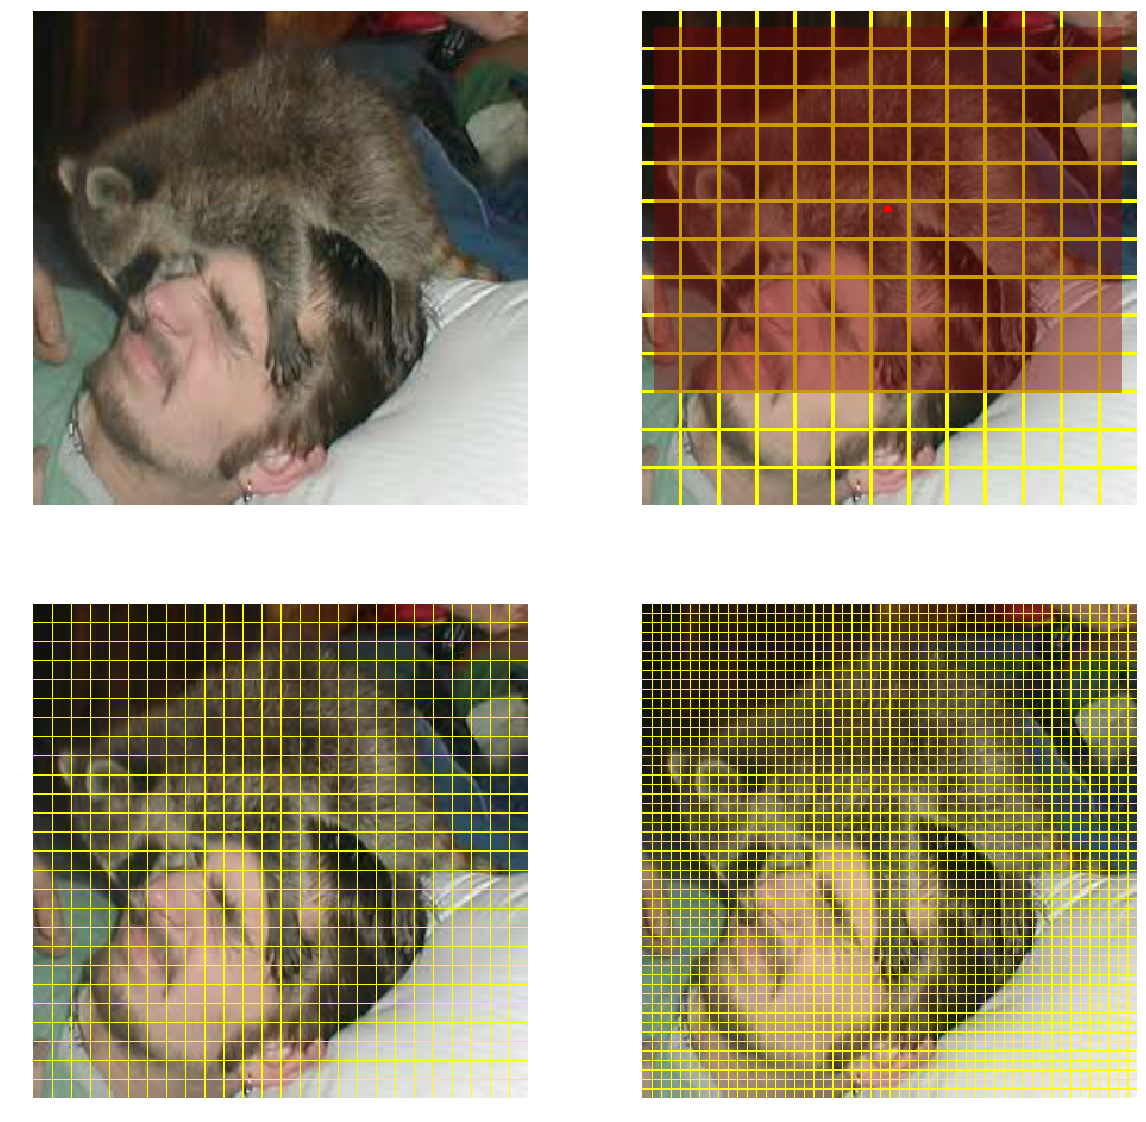

In [63]:
image,y1,y2,y3=iterator.next()
image=image.numpy()
y1=y1.numpy()
y2=y2.numpy()
y3=y3.numpy()

I,I1,I2,I3=decodeImage(image[0],y1[0],y2[0],y3[0],color=(255,255,0),linewidth=[2,1,1])
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(I)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(I1)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(I2)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(I3)
plt.axis('off')